In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pygmt
import os
import yaml
import pandas as pd
import h5py

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from scipy import interpolate

In [85]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import mathlib

In [86]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.5_03--10-16Hz/'

In [87]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_03--10-16Hz/


In [88]:
name_projects = []
name_projects.append('project/output_regular_v9.5_3x7/')
name_projects.append('project/output_regular_v9.5_5x13/')
name_projects.append('project/output_regular_v9.5_7x19/')

In [89]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [90]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
#dir_model_fund = dir_project + info_basic['rdir_model_fund']
#dir_model = dir_project + info_basic['rdir_model']
#dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo_Re-srl/'
dir_image = dir_project_workspace + 'paper_tomo_SRL-2.0/raw/'
dir_disp = dir_project + info_basic['rdir_disp_model']
dir_disp_pick = dir_project + info_basic['rdir_disp_pick']
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [91]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  ./project/output_regular_v9.5_3x7/
dir_project_targets:  ./project/output_regular_v9.5_5x13/


In [92]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

key_subworks_all = info_basic['key_subworks']
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
dir_disp_probes  = dir_project_probes + info_basic_probes['rdir_disp_autopick'] 

stations_this = {}
lat_stations_this = {}
lon_stations_this = {}
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_this[key] = stations_this
    lat_stations_this[key] = lat.astype(float)
    lon_stations_this[key] = lon.astype(float)

stations_probes = {}
lat_probes = {}
lon_probes = {}
lon_centroid_probes = []
lat_centroid_probes = []
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_this.astype(float)
    lon_probes[probe] = lon_this.astype(float)
    lon_centroid_probes.append(np.mean(lon_this.astype(float)))
    lat_centroid_probes.append(np.mean(lat_this.astype(float)))

stations_targets = {}
lat_targets = {}
lon_targets = {}
lon_centroid_targets = []
lat_centroid_targets = []
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)
    lon_centroid_targets.append(np.mean(lon_this.astype(float)))
    lat_centroid_targets.append(np.mean(lat_this.astype(float)))

In [93]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [94]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lon_centroid_partition = []
lat_centroid_partition = []
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat.astype(float)
    lon_stations_partition[key] = lon.astype(float)
    lon_centroid_partition.append(np.mean(lon.astype(float)))
    lat_centroid_partition.append(np.mean(lat.astype(float)))

In [95]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

In [96]:
flag_red = 0.001
flag_proj = 'M10c'

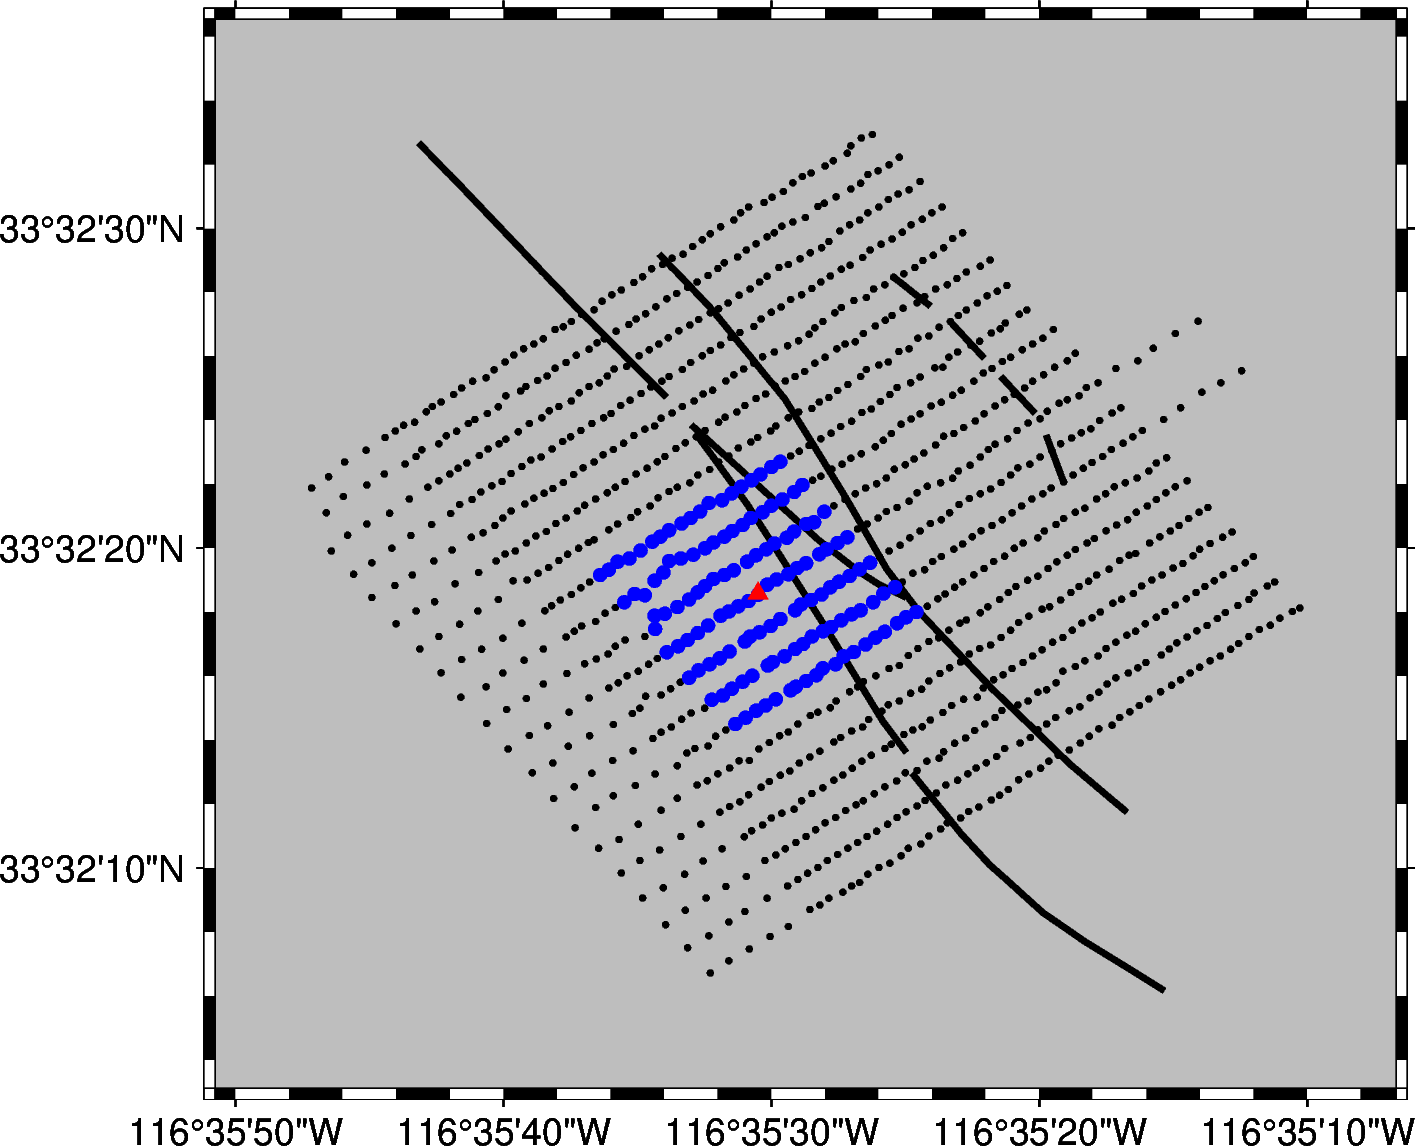

In [97]:
key_subwork = '26-10'
name_project_this = name_projects[2]

dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_partition_this = dir_project_this + info_basic_this['rdir_partition']

filepath = dir_partition_this + str(key_subwork) + '.txt'
stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
lat_stations_partition = lat.astype(float)
lon_stations_partition = lon.astype(float)
lon_centroid_partition = np.mean(lon.astype(float))
lat_centroid_partition = np.mean(lat.astype(float))

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_partition, y=lat_stations_partition, style='c0.12',fill='blue')
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'initial_partition_large.eps')

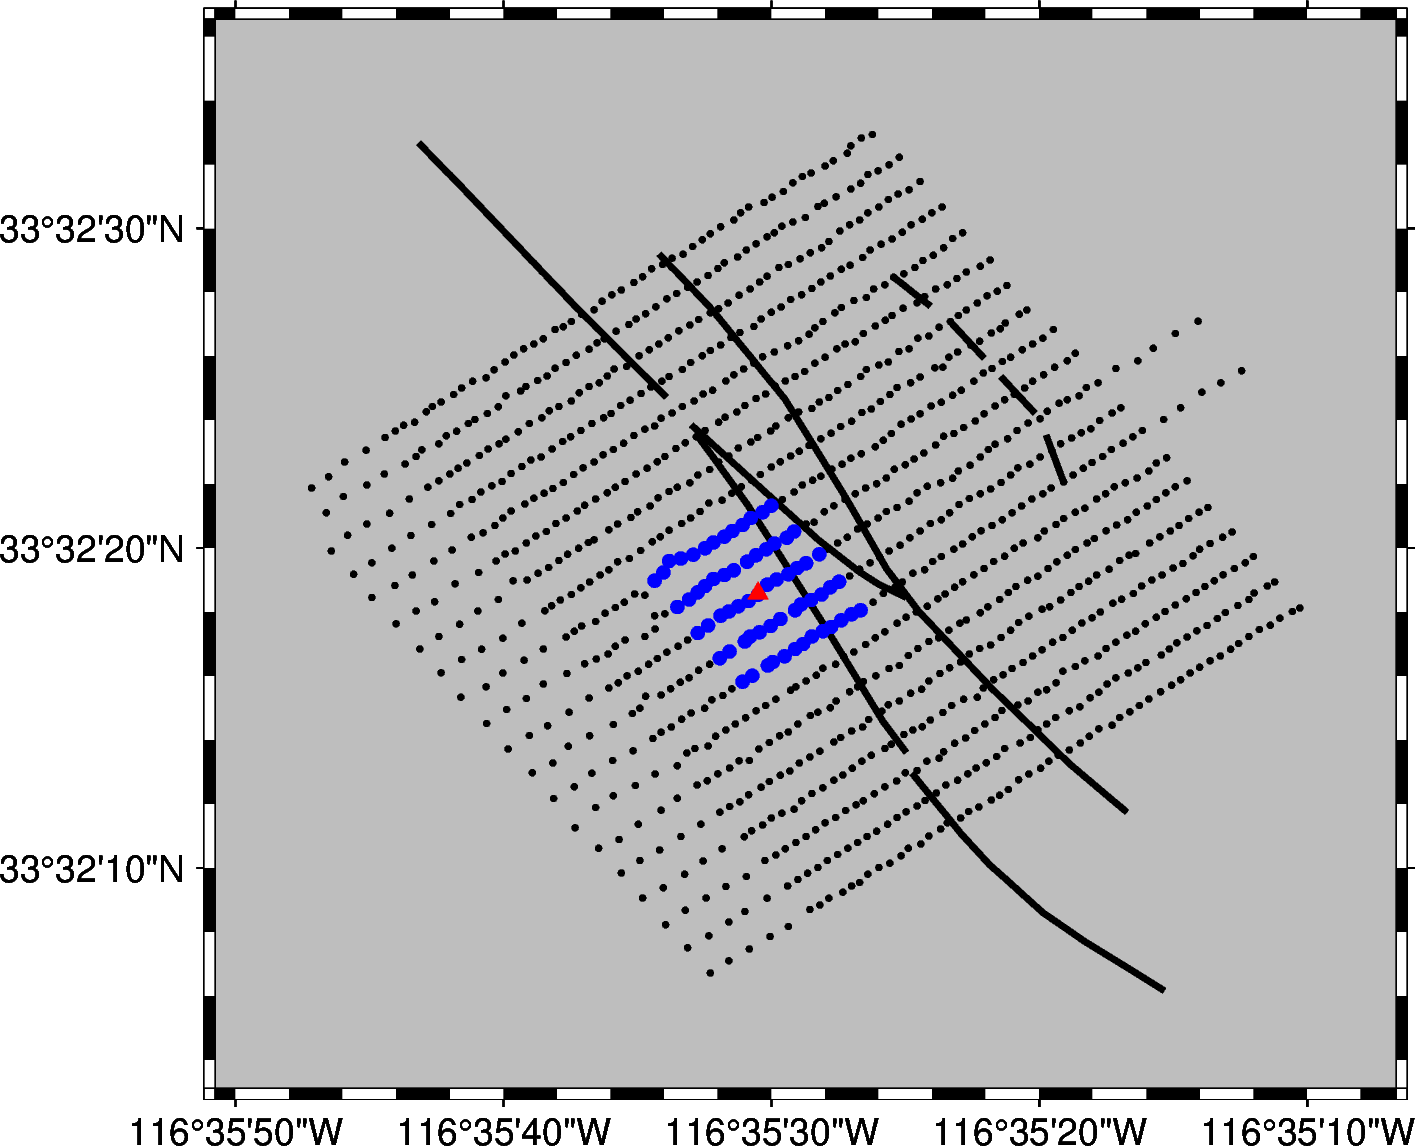

In [98]:
key_subwork = '26-10'
name_project_this = name_projects[1]

dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_partition_this = dir_project_this + info_basic_this['rdir_partition']

filepath = dir_partition_this + str(key_subwork) + '.txt'
stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
lat_stations_partition = lat.astype(float)
lon_stations_partition = lon.astype(float)
lon_centroid_partition = np.mean(lon.astype(float))
lat_centroid_partition = np.mean(lat.astype(float))

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_partition, y=lat_stations_partition, style='c0.12',fill='blue')
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'initial_partition_median.eps')

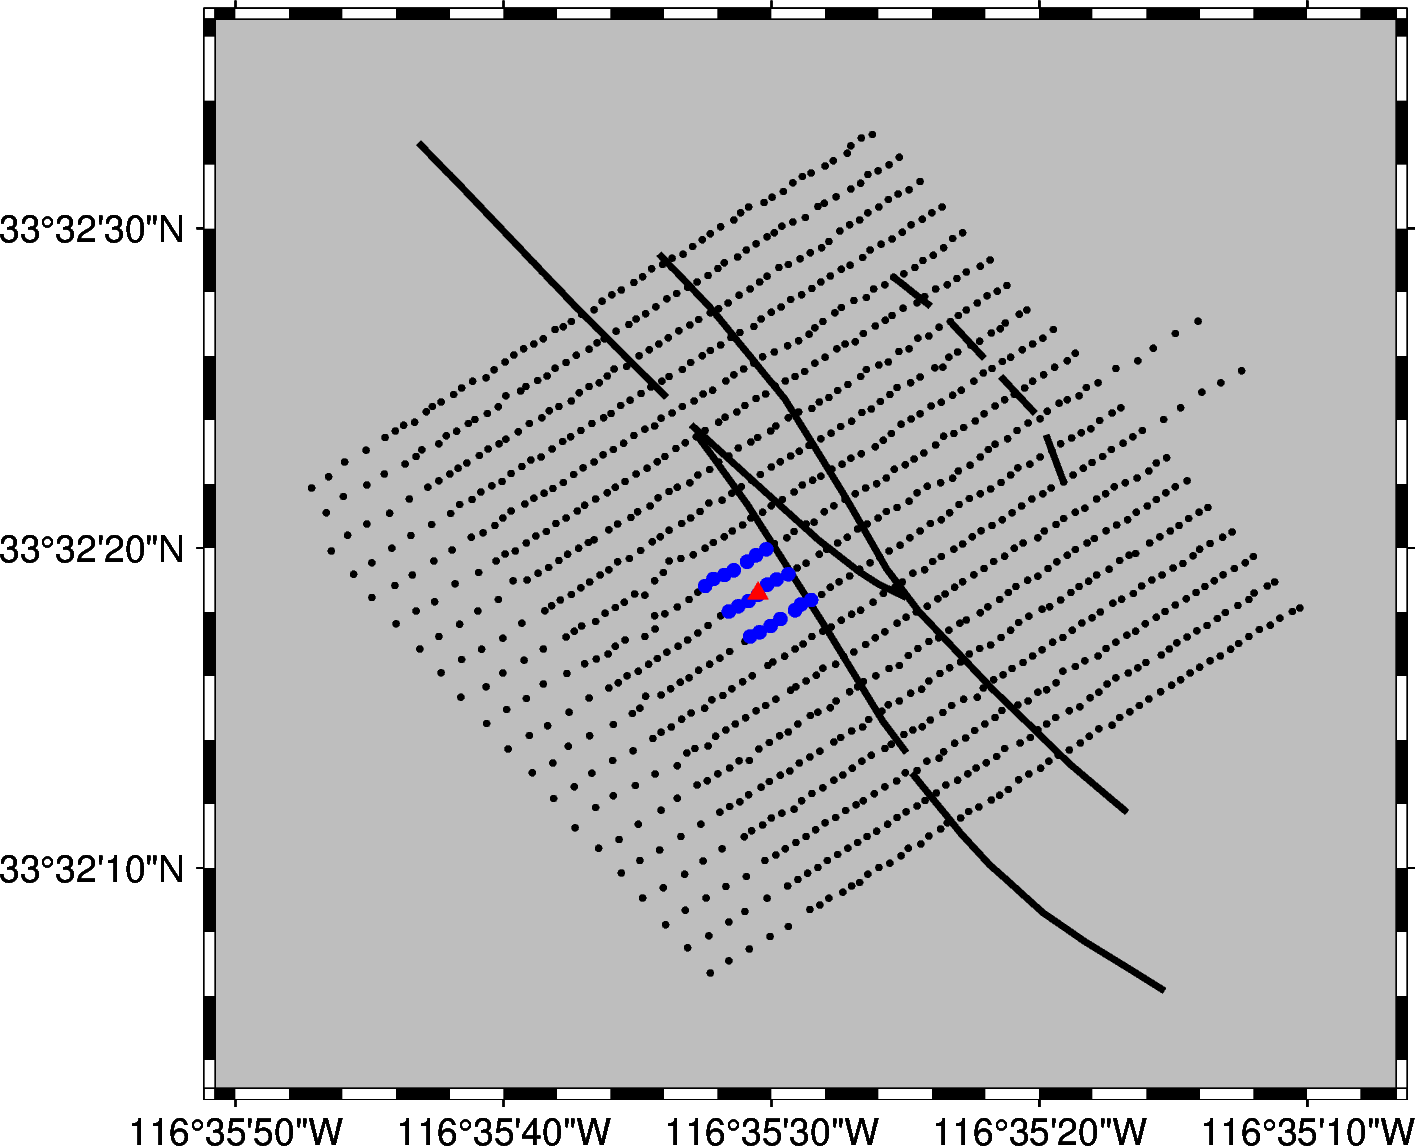

In [99]:
key_subwork = '26-10'
name_project_this = name_projects[0]

dir_project_this = dir_project_workspace + name_project_this
filename = dir_project_this+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_this = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_partition_this = dir_project_this + info_basic_this['rdir_partition']

filepath = dir_partition_this + str(key_subwork) + '.txt'
stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
lat_stations_partition = lat.astype(float)
lon_stations_partition = lon.astype(float)
lon_centroid_partition = np.mean(lon.astype(float))
lat_centroid_partition = np.mean(lat.astype(float))

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_partition, y=lat_stations_partition, style='c0.12',fill='blue')
fig.plot(x=lon_centroid_partition, y=lat_centroid_partition, style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'initial_partition_small.eps')